# <p style="text-align: center;">Electric Vehicles Based on Washington State Population</p>

   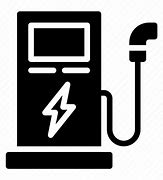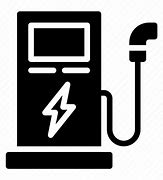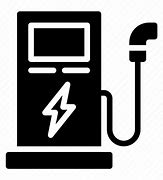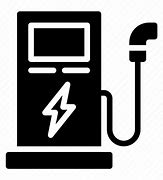

# Setup 


In [1]:

# Dependencies and Setup

import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import requests
import json
from census import Census
from config import api_key




## Importing Data and Cleaning

### Adding Census Data

In [2]:
#Load in API Census for the year 2020
c = Census(
    api_key,
    year = 2020
)
#Input Variables
census_data_counties = c.acs5.get(
    ("NAME", "B19013_001E", "B01003_001E", "B01002_001E", "B19301_001E", "B17001_002E"),
    {'for': 'county:*', 'in': 'state:53'}
)

# Convert the county data to a DataFrame
county_pd = pd.DataFrame(census_data_counties)

# Column renaming
county_pd = county_pd.rename(
    columns={
        "B01003_001E": "Population",
        "B19013_001E": "Household Income",
        "NAME": "County",
        "state": "State Code",
        "county": "County Code"
    }
)
# Remove " County, Washington" from the county names
county_pd["County"] = county_pd["County"].str.replace(" County, Washington", "")



# Configure the final DataFrame
county_pd = county_pd[
    [
        "County",
        "Population",        
        "Household Income",     
              
    ]
]



### Importing Vehicle CSV

In [3]:
#Load in Electric Vehicle Population csv
wa_data="data/Electric_Vehicle_Population_Data.csv"
#Read csv
wa_df = pd.read_csv(wa_data)

#Setting our Data to only include Washington State
wa_df= wa_df[wa_df['State'] == 'WA']
wa_df

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,1N4AZ0CP5D,Kitsap,Bremerton,WA,98310.0,2013,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,75,0,23.0,214384901,POINT (-122.61136499999998 47.575195000000065),PUGET SOUND ENERGY INC,5.303508e+10
1,1N4AZ1CP8K,Kitsap,Port Orchard,WA,98366.0,2019,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,150,0,26.0,271008636,POINT (-122.63926499999997 47.53730000000007),PUGET SOUND ENERGY INC,5.303509e+10
2,5YJXCAE28L,King,Seattle,WA,98199.0,2020,TESLA,MODEL X,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,293,0,36.0,8781552,POINT (-122.394185 47.63919500000003),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10
3,SADHC2S1XK,Thurston,Olympia,WA,98503.0,2019,JAGUAR,I-PACE,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,234,0,2.0,8308492,POINT (-122.8285 47.03646),PUGET SOUND ENERGY INC,5.306701e+10
4,JN1AZ0CP9B,Snohomish,Everett,WA,98204.0,2011,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,73,0,21.0,245524527,POINT (-122.24128499999995 47.91088000000008),PUGET SOUND ENERGY INC,5.306104e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138774,KNAGV4LD6L,Clark,Vancouver,WA,98686.0,2020,KIA,OPTIMA,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,28,0,17.0,122272881,POINT (-122.64839529999995 45.70104270000007),BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF C...,5.301104e+10
138775,7SAYGDEE1N,Thurston,Lacey,WA,98503.0,2022,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,22.0,187390038,POINT (-122.8285 47.03646),PUGET SOUND ENERGY INC,5.306701e+10
138776,5YJYGDEE7M,Benton,Richland,WA,99352.0,2021,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,8.0,181300416,POINT (-119.29441499999996 46.27187500000008),BONNEVILLE POWER ADMINISTRATION||CITY OF RICHL...,5.300501e+10
138777,WBY33AW08P,Pierce,Tacoma,WA,98443.0,2023,BMW,I4,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,25.0,224612055,POINT (-122.36463499999996 47.19449000000003),BONNEVILLE POWER ADMINISTRATION||CITY OF TACOM...,5.305394e+10


### Cleaning Data

In [4]:
#Unwanted data is being removed to provide for a more concise viewing of our DataFrame.
wa_df.drop(['Postal Code','Base MSRP','Legislative District','DOL Vehicle ID','2020 Census Tract','Vehicle Location','Electric Utility'], axis=1, inplace=True)

#Removing Electric Ranges that have a value of zero.
wa_df = wa_df[wa_df['Electric Range'] !=0]

# Setting a list of Urban Counties in Washington State
urban_counties = ['Clark', 'Thurston', 'Pierce', 'King', 'Kitsap', 'Snohomish', 'Whatcom', 'Spokane', 'Benton']

# Function to determine the type based on the county
def determine_type(county):
    if county in urban_counties:
        return 'Urban'
    else:
        return 'Rural'

# Adding the 'Type' column to the DataFrame
wa_df.insert(1, 'County Type', wa_df['County'].apply(determine_type))

In [5]:
#Merging both Data Frames
vehicle_census = pd.merge(county_pd, wa_df)


vehicle_census = pd.merge(county_pd, wa_df, on='County', how='left')

# View the new merged DataFrame


vehicle_census

,County,Population,Household Income,VIN (1-10),County Type,City,State,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range
0,Adams,19702.0,51601.0,2C4RC1N73L,Rural,Lind,WA,2020,CHRYSLER,PACIFICA,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,32
1,Adams,19702.0,51601.0,1FADP5CUXE,Rural,Ritzville,WA,2014,FORD,C-MAX,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,19
2,Adams,19702.0,51601.0,5YJYGDEE2L,Rural,Othello,WA,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,291
3,Adams,19702.0,51601.0,3FA6P0PU8G,Rural,Othello,WA,2016,FORD,FUSION,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,19
4,Adams,19702.0,51601.0,1G1FZ6S07L,Rural,Ritzville,WA,2020,CHEVROLET,BOLT EV,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,259
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78409,Whitman,49577.0,42288.0,JTDKARFP6J,Rural,Colfax,WA,2018,TOYOTA,PRIUS PRIME,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,25
78410,Whitman,49577.0,42288.0,KNDPYDAH3P,Rural,Pullman,WA,2023,KIA,SPORTAGE,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,34
78411,Whitman,49577.0,42288.0,5YJ3E1EA4L,Rural,Pullman,WA,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,266
78412,Whitman,49577.0,42288.0,1FADP3R49J,Rural,Pullman,WA,2018,FORD,FOCUS,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,100


# Exploratory Anaylsis & Visualizations

### Do newer vehicles have a further range?

   Model Year  Average Range
0        1997           39.0
1        1998           58.0
2        1999           74.0
3        2000           58.0
The Average sum is : 229.0


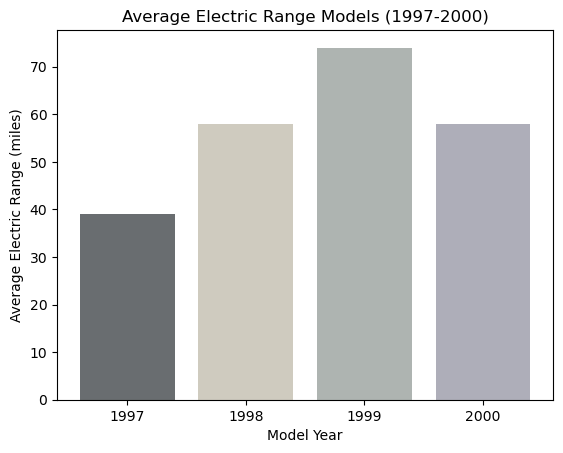

In [6]:
# Filter out rows with missing 'Electric Range' values and limit to 1997-2000 Model Years
vehicle_census_filtered = vehicle_census.dropna(subset=['Electric Range'])
vehicle_census_filtered['Model Year'] = (vehicle_census_filtered['Model Year'])
vehicle_census_filtered = vehicle_census_filtered[(vehicle_census_filtered['Model Year'] >=1997) & (vehicle_census_filtered['Model Year'] <=2000)]

# Group the data by 'Model Year' and calculate the average 'Electric Range' for each year
year_97_00= vehicle_census_filtered.groupby('Model Year')['Electric Range'].mean().reset_index()
year_97_00 = year_97_00.rename(columns={'Electric Range': 'Average Range'})
# Calculate the sum of averages for each year
sum_of_averages = year_97_00['Average Range'].sum()
print(year_97_00)
print(f'The Average sum is :', sum_of_averages)
# Sort the DataFrame by 'Model Year' in ascending order
year_97_00 = year_97_00.sort_values(by='Model Year')
colors = ['#2a2f33','#bbb6a5','#8c9491','#8c8c9c']

# Plot the bar graph
plt.bar(year_97_00['Model Year'], year_97_00['Average Range'], color=colors, alpha=0.7)

# Set the x-axis and y-axis labels
plt.xlabel('Model Year')
plt.ylabel('Average Electric Range (miles)')

# Set the title
plt.title('Average Electric Range Models (1997-2000)')
# Set the x-axis tick positions and labels
plt.xticks(year_97_00['Model Year'], year_97_00['Model Year'].astype(int))

#Save PNG
plt.savefig('png images/AvgERange_97_00.png')

# Show the plot
plt.show()

   Model Year  Average Range
0        2010     226.875000
1        2011      70.886768
2        2012      61.399879
3        2013      80.425784
The Average sum is : 439.5874309079517


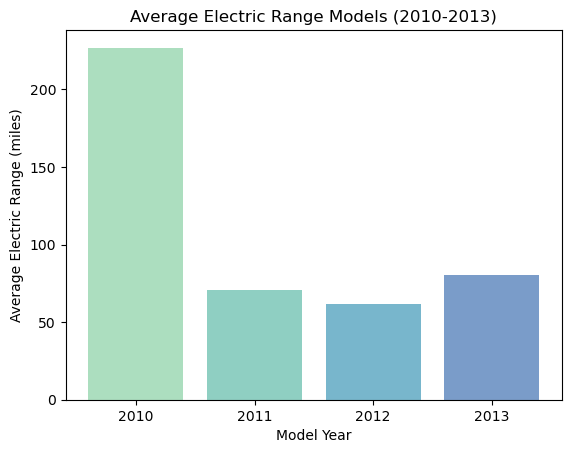

In [7]:
# Filter out rows with missing 'Electric Range' values and limit to 1997-2000 Model Years
vehicle_census_filtered = vehicle_census.dropna(subset=['Electric Range'])
vehicle_census_filtered['Model Year'] = (vehicle_census_filtered['Model Year'])
vehicle_census_filtered = vehicle_census_filtered[(vehicle_census_filtered['Model Year'] >=2010) & (vehicle_census_filtered['Model Year'] <=2013)]

## Group the data by 'Model Year' and calculate the average 'Electric Range' for each year
average_electric_range_by_year = vehicle_census_filtered.groupby('Model Year')['Electric Range'].mean().reset_index()

# Group the data by 'Model Year' and calculate the average 'Electric Range' for each year
year_10_13 = vehicle_census_filtered.groupby('Model Year')['Electric Range'].mean().reset_index()
year_10_13 = average_electric_range_by_year.rename(columns={'Electric Range': 'Average Range'})

# Calculate the sum of averages for each year
sum_of_averages = year_10_13['Average Range'].sum()
print(year_10_13)
print(f'The Average sum is :', sum_of_averages)

# Sort the DataFrame by 'Model Year' in ascending order
year_10_13 = year_10_13.sort_values(by='Model Year')
colors = ['#89d0a4', '#60bba8', '#3f97b7', '#4273b3']

# Plot the bar graph
plt.bar(year_10_13['Model Year'], year_10_13['Average Range'], color=colors, alpha=0.7)

# Set the x-axis and y-axis label
plt.xlabel('Model Year')
plt.ylabel('Average Electric Range (miles)')

# Set the title
plt.title('Average Electric Range Models (2010-2013)')
# Set the x-axis tick positions and labels
plt.xticks(year_10_13['Model Year'], year_10_13['Model Year'].astype(int))

#Save the PNG
plt.savefig('png images/AvgERange_10_13.png')
# Show the plot
plt.show()

   Model Year  Average Range
0        2014      81.012619
1        2015      97.651988
2        2016     101.292752
3        2017     111.603186
The Average sum is : 391.56054478875393


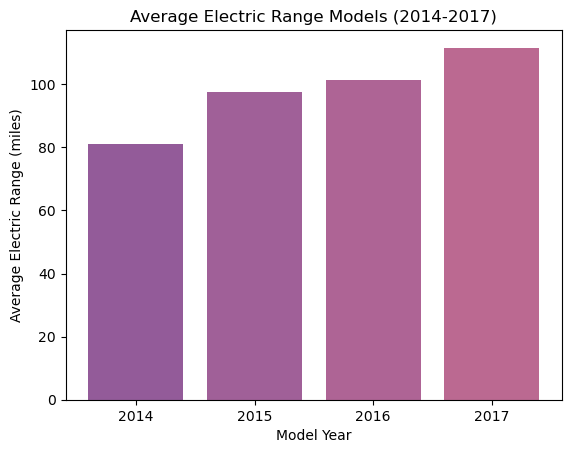

In [8]:
# Filter out rows with missing 'Electric Range' values and limit to 1997-2000 Model Years
vehicle_census_filtered = vehicle_census.dropna(subset=['Electric Range'])
vehicle_census_filtered['Model Year'] = (vehicle_census_filtered['Model Year'])
vehicle_census_filtered = vehicle_census_filtered[(vehicle_census_filtered['Model Year'] >=2014) & (vehicle_census_filtered['Model Year'] <=2017)]

# Group the data by 'Model Year' and calculate the average 'Electric Range' for each year
year_14_17 = vehicle_census_filtered.groupby('Model Year')['Electric Range'].mean().reset_index()
year_14_17 = year_14_17.rename(columns={'Electric Range': 'Average Range'})
# Calculate the sum of averages for each year
sum_of_averages = year_14_17['Average Range'].sum()
print(year_14_17)
print(f'The Average sum is :', sum_of_averages)

# Sort the DataFrame by 'Model Year' in ascending order
year_14_17 = year_14_17.sort_values(by='Model Year')
colors = ['#65156e', '#781c6d', '#8c2369', '#9f2a63', '#b1325a']

# Plot the bar graph
plt.bar(year_14_17['Model Year'], year_14_17['Average Range'], color=colors, alpha=0.7)

# Set the x-axis and y-axis labels
plt.xlabel('Model Year')
plt.ylabel('Average Electric Range (miles)')

# Set the title
plt.title('Average Electric Range Models (2014-2017)')
# Set the x-axis tick positions and labels
plt.xticks(year_14_17['Model Year'], year_14_17['Model Year'].astype(int))

#Save the PNG
plt.savefig('png images/AvgERange_14_17.png')

# Show the plot
plt.show()

   Model Year  Average Range
0        2018     156.246740
1        2019     176.394312
2        2020     241.197282
3        2021      48.253189
The Average sum is : 622.0915235106943


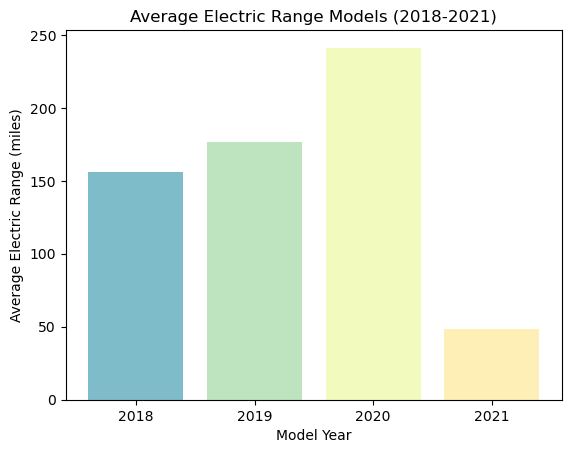

In [9]:
# Filter out rows with missing 'Electric Range' values and limit to 1997-2000 Model Years
vehicle_census_filtered = vehicle_census.dropna(subset=['Electric Range'])
vehicle_census_filtered['Model Year'] = (vehicle_census_filtered['Model Year'])
vehicle_census_filtered = vehicle_census_filtered[(vehicle_census_filtered['Model Year'] >=2018) & (vehicle_census_filtered['Model Year'] <=2021)]

# Group the data by 'Model Year' and calculate the average 'Electric Range' for each year
year_18_21 = vehicle_census_filtered.groupby('Model Year')['Electric Range'].mean().reset_index()
year_18_21 = year_18_21.rename(columns={'Electric Range': 'Average Range'})
# Calculate the sum of averages for each year
sum_of_averages = year_18_21['Average Range'].sum()
print(year_18_21)
print(f'The Average sum is :', sum_of_averages)
# Sort the DataFrame by 'Model Year' in ascending order
year_18_21 = year_18_21.sort_values(by='Model Year')
colors = ['#47a0b3', '#a2d9a4', '#edf8a3', '#fee999',]

# Plot the bar graph
plt.bar(year_18_21['Model Year'], year_18_21['Average Range'], color=colors, alpha=0.7)

# Set the x-axis and y-axis labels
plt.xlabel('Model Year')
plt.ylabel('Average Electric Range (miles)')

# Set the title
plt.title('Average Electric Range Models (2018-2021)')
# Set the x-axis tick positions and labels
plt.xticks(year_18_21['Model Year'], year_18_21['Model Year'].astype(int))

#Save the PNG
plt.savefig('png images/AvgERange_18_21.png')

# Show the plot
plt.show()

### Statistical Analysis of Electric Range Compared to Model Year

In [10]:
year_14_17
# Calculate the sum of averages for each year range
sum_of_averages_97_00 = year_97_00['Average Range'].sum()
sum_of_averages_10_13 = year_10_13['Average Range'].sum()
sum_of_averages_14_17 = year_14_17['Average Range'].sum()
sum_of_averages_18_21 = year_18_21['Average Range'].sum()

# Perform one-sample t-tests for each year range
t_statistic_97_00, p_value_97_00 = st.ttest_1samp(year_97_00['Average Range'], sum_of_averages)
t_statistic_10_13, p_value_10_13 = st.ttest_1samp(year_10_13['Average Range'], sum_of_averages)
t_statistic_14_17, p_value_14_17 = st.ttest_1samp(year_10_13['Average Range'], sum_of_averages)
t_statistic_18_21, p_value_18_21 = st.ttest_1samp(year_18_21['Average Range'], sum_of_averages)

# Display t-test results
print("T-Test Results for Years 1997-2000:")
print(f"T-Statistic: {t_statistic_97_00:.2f}, P-Value: {p_value_97_00:.6f}")
if p_value_97_00 < 0.05:
    print("Years 1997-2000 have a significantly different average electric range than the overall average.")
else:
    print("Years 1997-2000 do not have a significantly different average electric range than the overall average.")

print("\nT-Test Results for Years 2010-2013:")
print(f"T-Statistic: {t_statistic_10_13:.2f}, P-Value: {p_value_10_13:.6f}")
if p_value_10_13 < 0.05:
    print("Years 2010-2013 have a significantly different average electric range than the overall average.")
else:
    print("Years 2010-2013 do not have a significantly different average electric range than the overall average.")
    
print("\nT-Test Results for Years 2014-2017:")
print(f"T-Statistic: {t_statistic_14_17:.2f}, P-Value: {p_value_14_17:.6f}")
if p_value_14_17 < 0.05:
    print("Years 2014-2017 have a significantly different average electric range than the overall average.")
else:
    print("Years 2014-2017 do not have a significantly different average electric range than the overall average.")

print("\nT-Test Results for Years 2018-2021:")
print(f"T-Statistic: {t_statistic_18_21:.2f}, P-Value: {p_value_18_21:.6f}")
if p_value_18_21 < 0.05:
    print("Years 2018-2021 have a significantly different average electric range than the overall average.")
else:
    print("Years 2018-2021 do not have a significantly different average electric range than the overall average.")

T-Test Results for Years 1997-2000:
T-Statistic: -78.92, P-Value: 0.000004
Years 1997-2000 have a significantly different average electric range than the overall average.

T-Test Results for Years 2010-2013:
T-Statistic: -13.07, P-Value: 0.000967
Years 2010-2013 have a significantly different average electric range than the overall average.

T-Test Results for Years 2014-2017:
T-Statistic: -13.07, P-Value: 0.000967
Years 2014-2017 have a significantly different average electric range than the overall average.

T-Test Results for Years 2018-2021:
T-Statistic: -11.64, P-Value: 0.001362
Years 2018-2021 have a significantly different average electric range than the overall average.


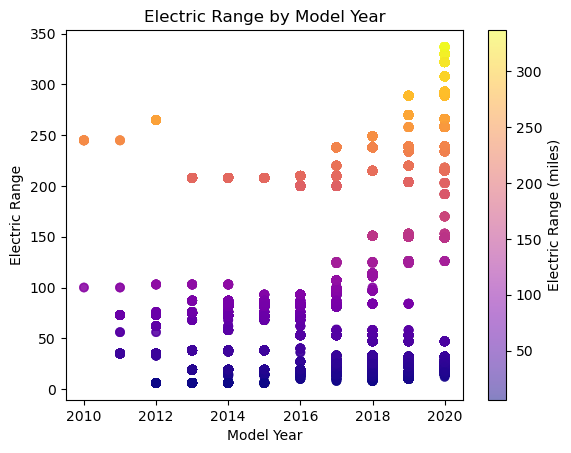

In [11]:
vehicle_census_filtered = vehicle_census.dropna(subset=['Electric Range'])
vehicle_census_filtered['Model Year'] = (vehicle_census_filtered['Model Year'])
vehicle_census_filtered= vehicle_census_filtered[(vehicle_census_filtered['Model Year'] >=2010) & (vehicle_census_filtered['Model Year'] <=2020)]
# Set the color for the scatter plot
colors = plt.colormaps.get_cmap('plasma')  

# Plot the scatter plot
plt.scatter(vehicle_census_filtered['Model Year'], vehicle_census_filtered['Electric Range'],  c=vehicle_census_filtered['Electric Range'], cmap=colors, alpha=0.5)
plt.colorbar(label='Electric Range (miles)')
# Set the x-axis and y-axis labels
plt.xlabel('Model Year')
plt.ylabel('Electric Range')

# Set the title
plt.title('Electric Range by Model Year')

#Save the PNG
plt.savefig('png images/Sct_ERange_MYear.png')

# Show the plot
plt.show()

The correlation between Model Year and Electric Range is: 0.51
Linear Regression Analysis:
Slope: 21.375898193409686
Intercept: -42972.690939084794
R-value: 0.5105257012807282
P-value: 0.0
R-squared value: 0.26063649166817926


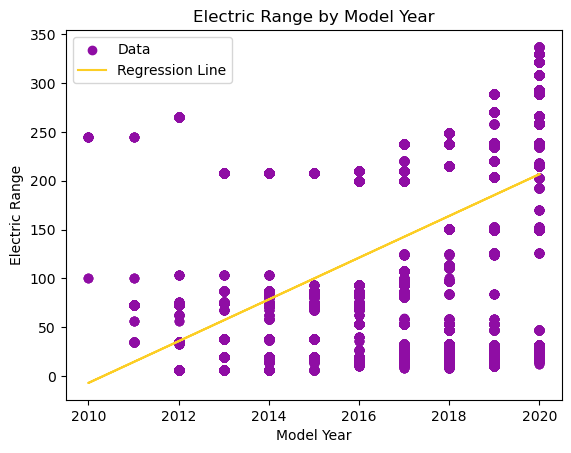

In [12]:
# Check if 'Model Year' column has varying values
if len(vehicle_census_filtered['Model Year'].unique()) == 1:
    print("Error: 'Model Year' column has constant values. Cannot perform linear regression.")
else:

# Perform linear regression
    slope, intercept, rvalue, pvalue, _ = st.linregress(vehicle_census_filtered['Model Year'], vehicle_census_filtered['Electric Range'])
# Create the regression line data
    regression_line = slope * vehicle_census_filtered['Model Year'] + intercept
# Calculate R-squared value
    r_squared = rvalue ** 2
# Calculate the correlation coefficient
    correlation_coef, _ = st.pearsonr(vehicle_census_filtered['Model Year'], vehicle_census_filtered['Electric Range'])
    print("The correlation between Model Year and Electric Range is: {:.2f}".format(correlation_coef))
    print("Linear Regression Analysis:")
    print("Slope:", slope)
    print("Intercept:", intercept)
    print("R-value:", rvalue)
    print("P-value:", pvalue)
    print("R-squared value:", r_squared)
#Set the color for the scatter plot and regression line
    cmap = plt.get_cmap('plasma')  # Choose a colormap (e.g., 'coolwarm', 'viridis', 'plasma', etc.)

# Plot the scatter plot with regression line
    plt.scatter(vehicle_census_filtered['Model Year'], vehicle_census_filtered['Electric Range'], color=cmap(0.3), label='Data')
    plt.plot(vehicle_census_filtered['Model Year'], regression_line, color=cmap(0.9), label='Regression Line')

# Set the x-axis and y-axis labels
    plt.xlabel('Model Year')
    plt.ylabel('Electric Range')

# Set the title
    plt.title('Electric Range by Model Year')

# Show the legend
    plt.legend()

#Save the PNG
    plt.savefig('png images/Sct_ERange_MYear_REg.png')
    
# Show the plot
    plt.show()

## What is the most popular make and model? Has this changed over time?

In [14]:
#Making new column to hold the values of what type of vehicles that were purchased in Washington for each year
vehicle_census_filtered = vehicle_census.dropna(subset=['Electric Range'])
vehicle_census_filtered['Model Year'] = (vehicle_census_filtered['Model Year'])
vehicle_census_filtered = vehicle_census_filtered[(vehicle_census_filtered['Model Year'] >=2010) & (vehicle_census_filtered['Model Year'] <=2020)]
make_df = vehicle_census_filtered.groupby(['Make','Model Year'])['Make'].count().reset_index(name='Count')
#Filtering the data to get a count of the most popular greater than 500
make_df_filtered = make_df[make_df['Count'] >= 500]

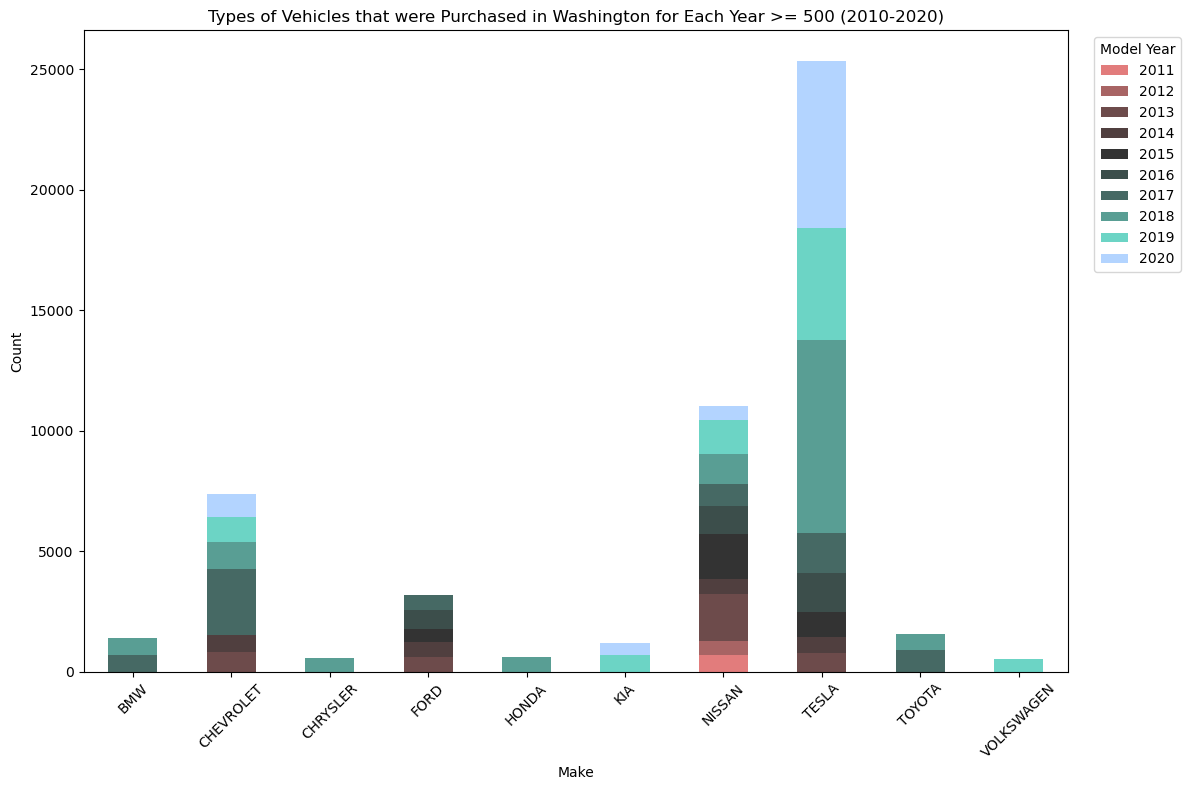

In [15]:
# Pivot the DataFrame to create a stacked bar plot
make_pivot = make_df_filtered.pivot(index='Make', columns='Model Year', values='Count').fillna(0)
#Customize colors
custom_colors = ["#e27c7c", "#a86464", "#6d4b4b", "#503f3f", "#333333", "#3c4e4b", "#466964", "#599e94", "#6cd4c5","#b3d4ff"]
# Plot the stacked bar chart
make_pivot.plot(kind='bar', stacked=True, figsize=(12, 8),color=custom_colors)
plt.xlabel('Make')
plt.ylabel('Count')
plt.title('Types of Vehicles that were Purchased in Washington for Each Year >= 500 (2010-2020)')
plt.legend(title='Model Year', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()


#Save the PNG
plt.savefig('png images/SBar_ModelYear.png')

plt.show()

   Model Year    Model    Count
0        2011     LEAF  7639552
1        2012     LEAF  6483712
2        2012  MODEL S   775680


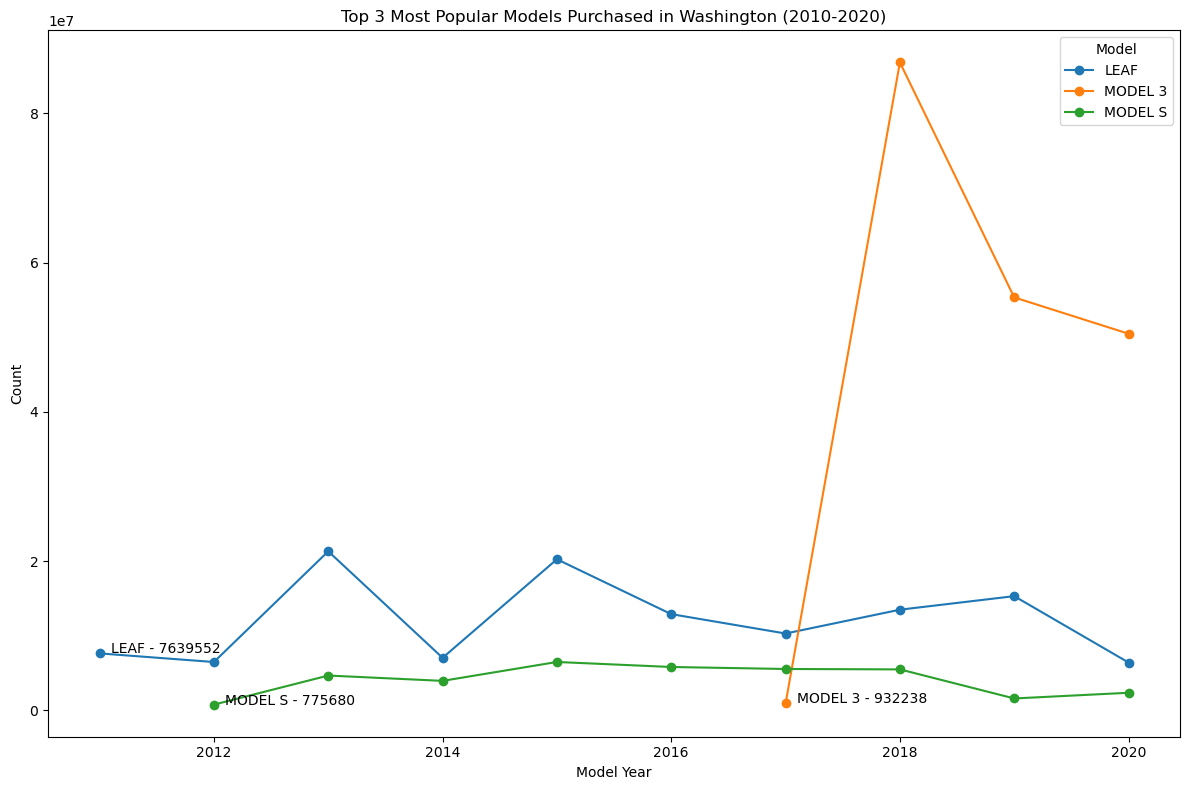

In [16]:

# Step 1: Group the data by "Model" and "Make" and calculate the count for each model.
model_counts = wa_df.groupby(['Model', 'Make'])['Model Year'].count().reset_index(name='Count')

# Step 2: Sort the DataFrame by the count of each model in descending order.
model_counts_sorted = model_counts.sort_values(by='Count', ascending=False)

# Step 3: Select the top 3 rows, which represent the most popular models.
top_3_models = model_counts_sorted.head(3)

# Step 4: Merge the original DataFrame with the top 3 models.
wa_df_top_3_models = pd.merge(wa_df, top_3_models, on=['Model', 'Make'])

# Step 5: Group the data by "Model Year" and sum the "Count" for each model year.
model_year_counts = wa_df_top_3_models.groupby(['Model Year', 'Model'])['Count'].sum().reset_index()

#Print Data Frame
print(model_year_counts.head(3))

# Step 6: Pivot the DataFrame to have each model as a separate column.
model_year_pivot = model_year_counts.pivot(index='Model Year', columns='Model', values='Count')

# Step 7: Plot the line graph for the top 3 models.
ax = model_year_pivot.plot(kind='line', marker='o', figsize=(12, 8))

# Set the x-axis and y-axis labels
plt.xlabel('Model Year')
plt.ylabel('Count')
plt.title('Top 3 Most Popular Models Purchased in Washington (2010-2020)')

# Add a legend for the top 3 models
top_models = top_3_models['Model'].values
for model in top_models:
    count = model_year_counts[model_year_counts['Model'] == model]['Count'].iloc[0]
    year = model_year_counts[model_year_counts['Model'] == model]['Model Year'].iloc[0]
    ax.annotate(f"{model} - {count}", xy=(year, count), xytext=(8, 0), textcoords='offset points')

plt.tight_layout()

#Save the PNG
plt.savefig('png images/LineTop3_ModelYear.png')

# Show the plot
plt.show()

#### Visualization of Electric/Hybrid Vehicles in the State of Washington (2010-2020)

        Make  Model Year  Count
0  CHEVROLET        1997      1
1       FORD        1998      1
2       FORD        1999      4
3       FORD        2000      9


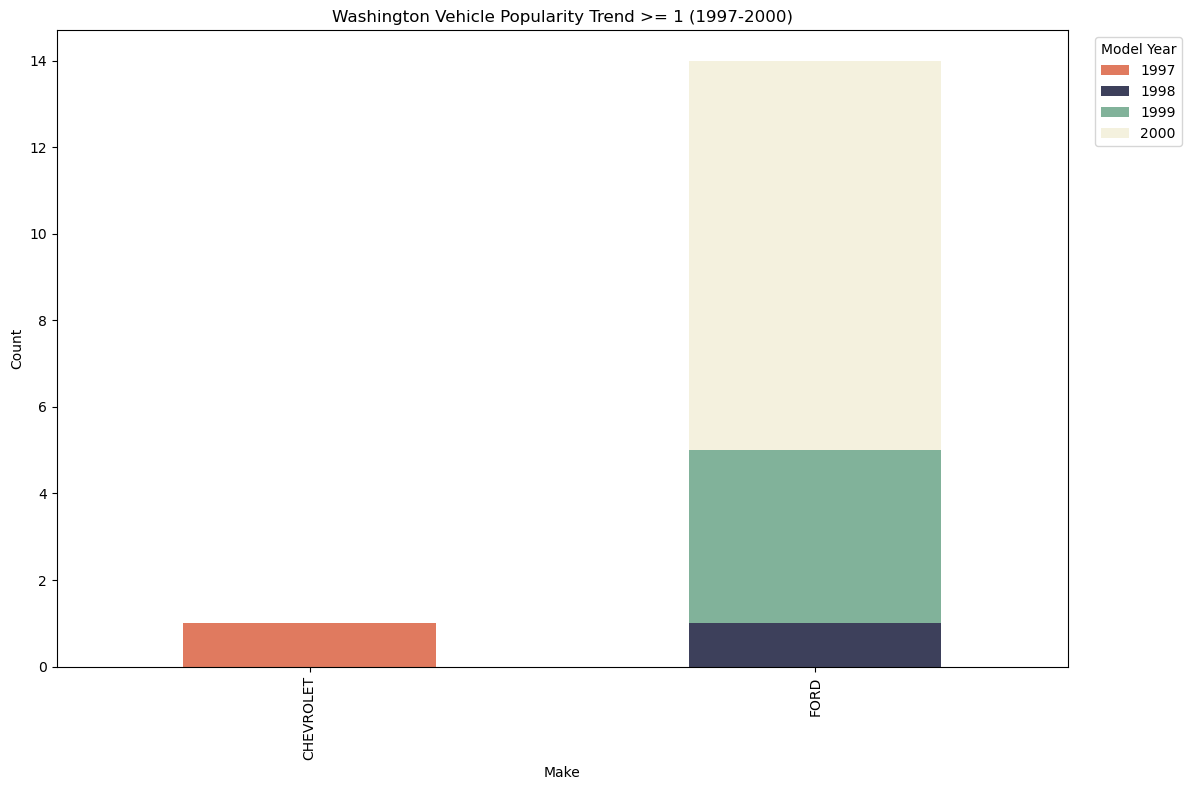

In [17]:
#Making new column to hold the values of what type of vehicles that were purchased in Washington for each year
vehicle_census_filtered = vehicle_census.dropna(subset=['Electric Range'])
vehicle_census_filtered['Model Year'] = (vehicle_census_filtered['Model Year'])
vehicle_97_2000 = vehicle_census_filtered[(vehicle_census_filtered['Model Year'] >=1997) & (vehicle_census_filtered['Model Year'] <=2000)]
make_df_97_2000 = vehicle_97_2000.groupby(['Make','Model Year'])['Make'].count().reset_index(name='Count')

#Filtering the data to get a count of the most popular vehicle greater than 500
make_df_97_2000 = make_df_97_2000[make_df_97_2000['Count']>=1]
#Print
print(make_df_97_2000)
# Pivot the DataFrame to create a stacked bar plot
make_pivot_97_2000 = make_df_97_2000.pivot(index='Make', columns='Model Year', values='Count').fillna(0)

#Customize colors
custom_colors = ["#E07A5F","#3D405B","#81B29A","#F4F1DE"]

# Plot the stacked bar chart and properties
make_pivot_97_2000.plot(kind='bar', stacked=True, figsize=(12, 8),color=custom_colors)
plt.xlabel('Make')
plt.ylabel('Count')
plt.title('Washington Vehicle Popularity Trend >= 1 (1997-2000)')
plt.legend(title='Model Year', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()

#Save the PNG
plt.savefig('png images/Bar_Popularity97_00.png')

plt.show()

          Make  Model Year  Count
2    CHEVROLET        2011     76
3    CHEVROLET        2012    474
4    CHEVROLET        2013    798
5         FIAT        2013    107
8         FORD        2013    621
9   MITSUBISHI        2012     42
10      NISSAN        2011    694
11      NISSAN        2012    589
12      NISSAN        2013   1937
13       SMART        2013     29
14       TESLA        2010     21
16       TESLA        2012    128
17       TESLA        2013    771
19      TOYOTA        2012    386
20      TOYOTA        2013    298


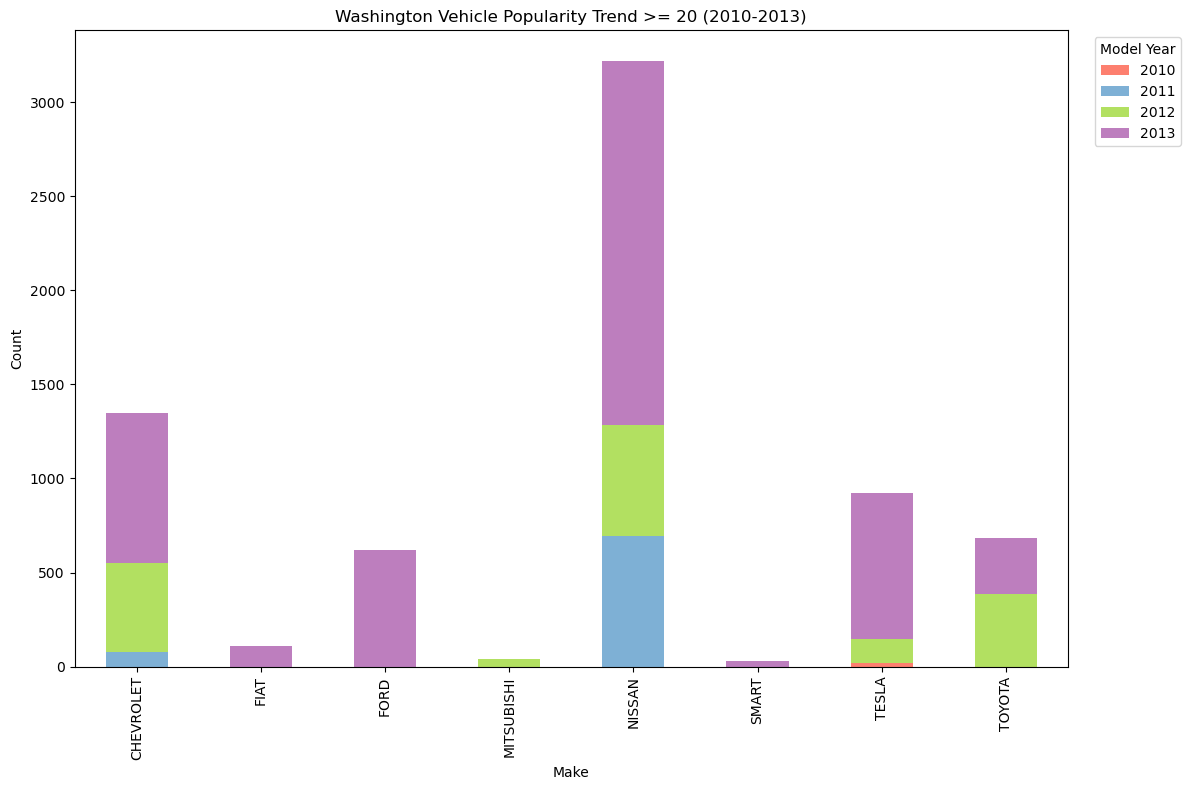

In [18]:
#Making new column to hold the values of what type of vehicles that were purchased in Washington for each year
vehicle_census_filtered = vehicle_census.dropna(subset=['Electric Range'])
vehicle_census_filtered['Model Year'] = (vehicle_census_filtered['Model Year'])
vehicle_10_13 = vehicle_census_filtered[(vehicle_census_filtered['Model Year'] >=2010) & (vehicle_census_filtered['Model Year'] <=2013)]
make_df_10_13 = vehicle_10_13.groupby(['Make','Model Year'])['Make'].count().reset_index(name='Count')

#Filtering the data to get a count of the most popular vehicle greater than 500
make_df_10_13 = make_df_10_13[make_df_10_13['Count']>=20]

#Print
print(make_df_10_13)
# Pivot the DataFrame to create a stacked bar plot
make_pivot_10_13 = make_df_10_13.pivot(index='Make', columns='Model Year', values='Count').fillna(0)

#Customize colors
custom_colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe"]

# Plot the stacked bar chart and properties
make_pivot_10_13.plot(kind='bar', stacked=True, figsize=(12, 8),color=custom_colors)
plt.xlabel('Make')
plt.ylabel('Count')
plt.title('Washington Vehicle Popularity Trend >= 20 (2010-2013)')
plt.legend(title='Model Year', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()

#Save the PNG
plt.savefig('png images/Bar_Popularity10_13.png')

plt.show()

          Make  Model Year  Count
0         AUDI        2016    212
2          BMW        2014    447
3          BMW        2015    398
4          BMW        2016    374
5          BMW        2017    674
9    CHEVROLET        2014    713
10   CHEVROLET        2015    470
11   CHEVROLET        2016    301
12   CHEVROLET        2017   2738
15        FIAT        2015    239
18        FORD        2014    613
19        FORD        2015    543
20        FORD        2016    771
21        FORD        2017    653
26         KIA        2016    398
27         KIA        2017    206
35      NISSAN        2014    640
36      NISSAN        2015   1840
37      NISSAN        2016   1172
38      NISSAN        2017    936
47       TESLA        2014    653
48       TESLA        2015   1071
49       TESLA        2016   1617
50       TESLA        2017   1635
51      TOYOTA        2014    218
53      TOYOTA        2017    896
55  VOLKSWAGEN        2016    328


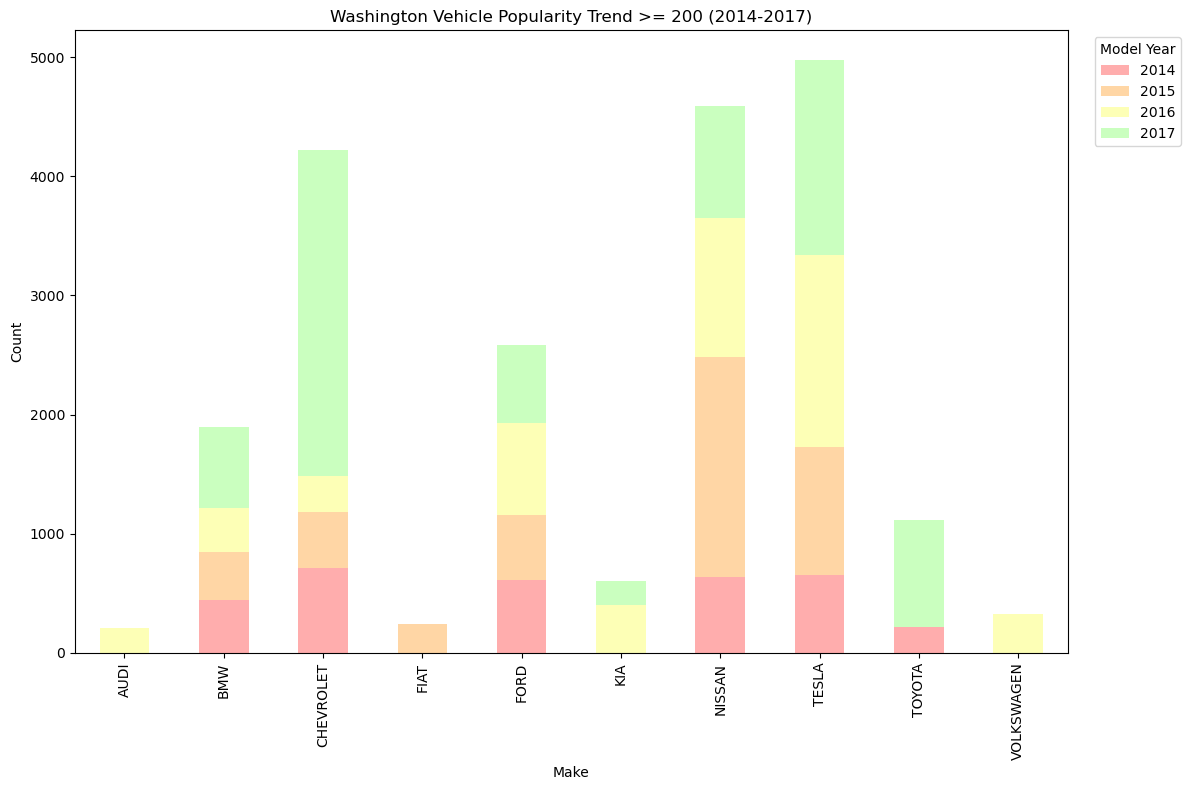

In [19]:
#Making new column to hold the values of what type of vehicles that were purchased in Washington for each year
vehicle_census_filtered = vehicle_census.dropna(subset=['Electric Range'])
vehicle_census_filtered['Model Year'] = (vehicle_census_filtered['Model Year'])
vehicle_14_17 = vehicle_census_filtered[(vehicle_census_filtered['Model Year'] >=2014) & (vehicle_census_filtered['Model Year'] <=2017)]
make_df_14_17 = vehicle_14_17.groupby(['Make','Model Year'])['Make'].count().reset_index(name='Count')

#Filtering the data to get a count of the most popular vehicle greater than 500
make_df_14_17 = make_df_14_17[make_df_14_17['Count']>=200]
#Print
print(make_df_14_17)
# Pivot the DataFrame to create a stacked bar plot
make_pivot_14_17 = make_df_14_17.pivot(index='Make', columns='Model Year', values='Count').fillna(0)

#Customize colors
custom_colors = ["#FFADAD", "#FFD6A5", "#FDFFB6", "#CAFFBF"]

# Plot the stacked bar chart and properties
make_pivot_14_17.plot(kind='bar', stacked=True, figsize=(12, 8),color=custom_colors)
plt.xlabel('Make')
plt.ylabel('Count')
plt.title('Washington Vehicle Popularity Trend >= 200 (2014-2017)')
plt.legend(title='Model Year', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()

#Save the PNG
plt.savefig('png images/Bar_Popularity14_17.png')

plt.show()

          Make  Model Year  Count
1         AUDI        2019    416
2         AUDI        2020    228
3         AUDI        2021    461
6          BMW        2018    707
7          BMW        2019    303
9          BMW        2021    599
11   CHEVROLET        2018   1152
12   CHEVROLET        2019   1007
13   CHEVROLET        2020    957
14    CHRYSLER        2018    545
16    CHRYSLER        2020    286
17    CHRYSLER        2021    483
24       HONDA        2018    610
30     HYUNDAI        2020    215
34        JEEP        2021    611
35         KIA        2018    310
36         KIA        2019    673
37         KIA        2020    508
54      NISSAN        2018   1226
55      NISSAN        2019   1391
56      NISSAN        2020    583
65       TESLA        2018   8027
66       TESLA        2019   4642
67       TESLA        2020   6938
68      TOYOTA        2018    654
70      TOYOTA        2020    331
71      TOYOTA        2021   1003
73  VOLKSWAGEN        2019    514
74       VOLVO

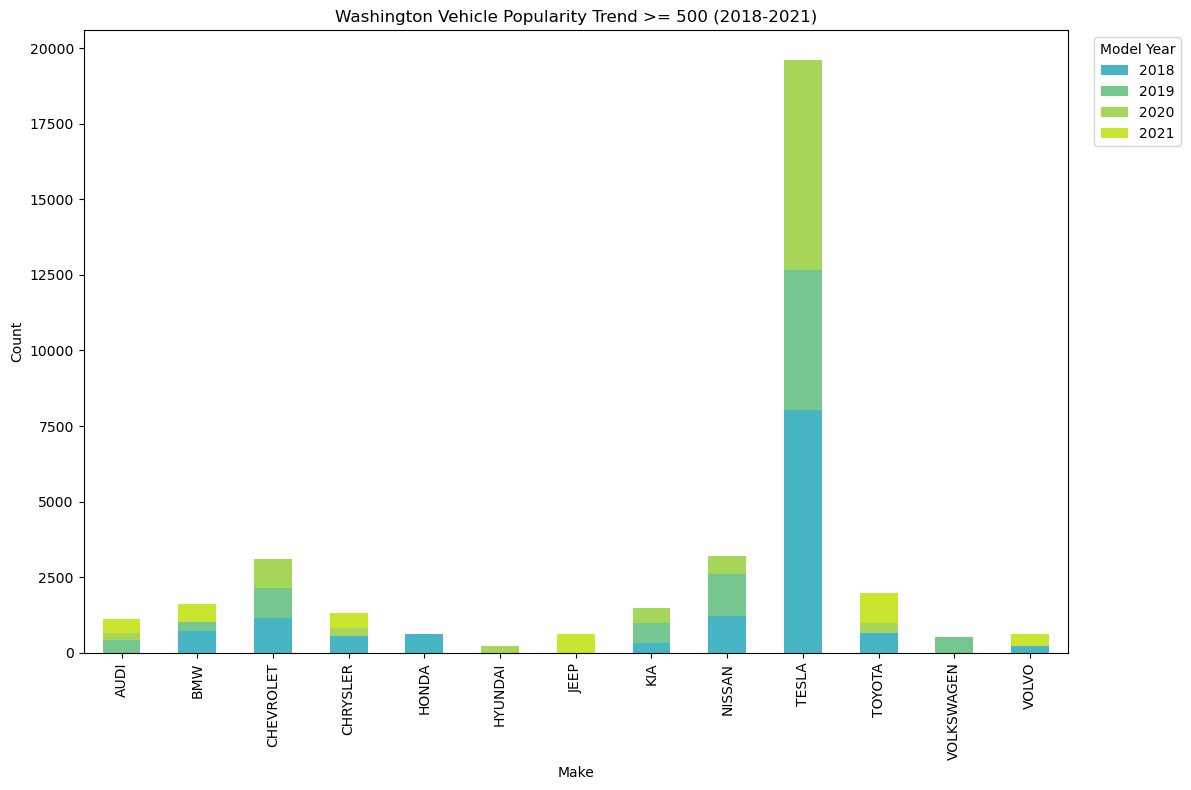

In [20]:
#Making new column to hold the values of what type of vehicles that were purchased in Washington for each year
vehicle_census_filtered = vehicle_census.dropna(subset=['Electric Range'])
vehicle_census_filtered['Model Year'] = (vehicle_census_filtered['Model Year'])
vehicle_18_21= vehicle_census_filtered[(vehicle_census_filtered['Model Year'] >=2018) & (vehicle_census_filtered['Model Year'] <=2021)]
make_df_18_21 = vehicle_18_21.groupby(['Make','Model Year'])['Make'].count().reset_index(name='Count')
#Filtering the data to get a count of the most popular greater than 500
make_df_18_21 = make_df_18_21[make_df_18_21['Count'] >= 200]
#Print
print(make_df_18_21)
# Pivot the DataFrame to create a stacked bar plot
make_pivot_18_21 = make_df_18_21.pivot(index='Make', columns='Model Year', values='Count').fillna(0)

#Customize colors
custom_colors = ["#48b5c4", "#76c68f", "#a6d75b", "#c9e52f"]

# Plot the stacked bar chart and properties
make_pivot_18_21.plot(kind='bar', stacked=True, figsize=(12, 8),color=custom_colors)
plt.xlabel('Make')
plt.ylabel('Count')
plt.title('Washington Vehicle Popularity Trend >= 500 (2018-2021)')
plt.legend(title='Model Year', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()

#Save the PNG
plt.savefig('png images/Bar_Popularity18_21.png')

plt.show()

## Are Battery Powered Vehicles more popular in Urban Areas?

### Total Electric Cars compared to County Type (urban vs. rural)

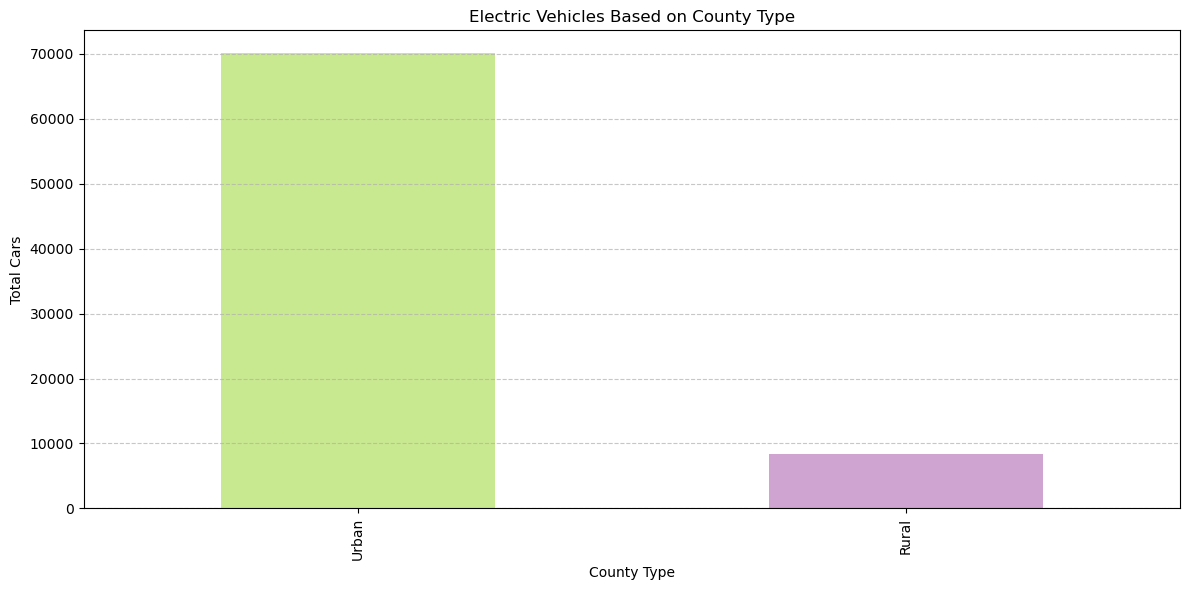

In [21]:
# Group the data by county and calculate the total number of cars in each county
total_cars_by_county = vehicle_census.groupby('County Type')['Make'].count()

# Calculate the correlation between the total cars and electric range for each county
total_cars_by_county = total_cars_by_county.sort_values(ascending=False)

# Plot the bar graph
plt.figure(figsize=(12, 6))
total_cars_by_county.plot(kind='bar', color=["#b2e061", "#bd7ebe"], alpha=0.7)
plt.xlabel('County Type')
plt.ylabel('Total Cars')
plt.title('Electric Vehicles Based on County Type')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


#Save the PNG
plt.savefig('png images/Bar_EVehicle_County.png')

plt.show()

### Electric Vehicle Type compared to County Type

In [22]:

bev= vehicle_census[vehicle_census['Electric Vehicle Type'] == 'Battery Electric Vehicle (BEV)']
phev = vehicle_census[vehicle_census['Electric Vehicle Type'] == 'Plug-in Hybrid Electric Vehicle (PHEV)']


In [23]:
bev_county_type = bev.groupby('County Type').size().reset_index(name='BEV Count')
phev_county_type = phev.groupby('County Type').size().reset_index(name='PHEV Count')

merged_df = pd.merge(bev_county_type, phev_county_type, on='County Type', how='outer')
merged_df

,County Type,BEV Count,PHEV Count
0,Rural,4507,3832
1,Urban,42028,28047


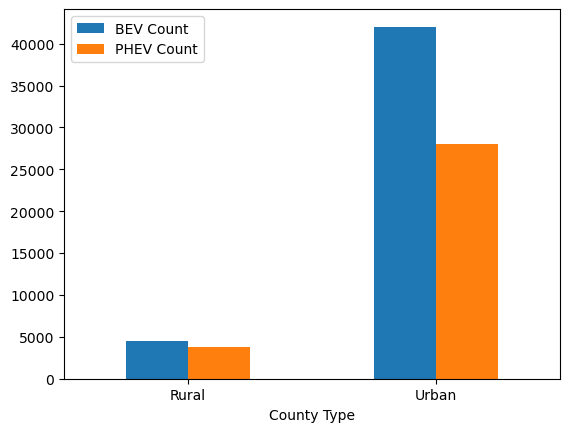

In [24]:
merged_df.plot.bar(x='County Type', rot = 0)


#Save the PNG
plt.savefig('png images/Bar_EVType_County.png')

plt.show()